#Import Data and Setup

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]


import numpy as np
import keras
from keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import scipy.io
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/brooksideas/weapon-detection-deep-learning.git

Cloning into 'weapon-detection-deep-learning'...
remote: Enumerating objects: 17588, done.
remote: Counting objects: 100% (5897/5897), done.
remote: Compressing objects: 100% (5184/5184), done.
remote: Total 17588 (delta 17), reused 5846 (delta 9), pack-reused 11691
Receiving objects: 100% (17588/17588), 419.79 MiB | 25.25 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Updating files: 100% (11726/11726), done.


In [ ]:
dataset_path = "/content/drive/MyDrive/weapon-detection-deep-learning/weapon_train_test_dataset/data/weapon_detection/train_test_data"

#Prepare Dataset

In [ ]:
path_images = "/content/weapon-detection-deep-learning/weapon_train_test_dataset/data/weapon_detection/train_test_data/images/train"
path_annot = "/content/weapon-detection-deep-learning/weapon_train_test_dataset/data/weapon_detection/train_test_data/labels/train"

In [ ]:
# Get file lists for images and annotations
image_paths = [os.path.join(path_images, f) for f in os.listdir(path_images) if f.endswith('.jpg')]
annot_paths = [os.path.join(path_annot, f) for f in os.listdir(path_annot) if f.endswith('.txt')]

image_paths.sort()
annot_paths.sort()

image_size = 224  # Resize input images to this size

images, targets = [], []

Image paths: ['/content/weapon-detection-deep-learning/weapon_train_test_dataset/data/weapon_detection/train_test_data/images/train/ABbframe00154.jpg', '/content/weapon-detection-deep-learning/weapon_train_test_dataset/data/weapon_detection/train_test_data/images/train/ABbframe00160.jpg', '/content/weapon-detection-deep-learning/weapon_train_test_dataset/data/weapon_detection/train_test_data/images/train/ABbframe00166.jpg', '/content/weapon-detection-deep-learning/weapon_train_test_dataset/data/weapon_detection/train_test_data/images/train/ABbframe00169.jpg', '/content/weapon-detection-deep-learning/weapon_train_test_dataset/data/weapon_detection/train_test_data/images/train/ABbframe00190.jpg']
Annotation paths: ['/content/weapon-detection-deep-learning/weapon_train_test_dataset/data/weapon_detection/train_test_data/labels/train/ABbframe00154.txt', '/content/weapon-detection-deep-learning/weapon_train_test_dataset/data/weapon_detection/train_test_data/labels/train/ABbframe00160.txt', '

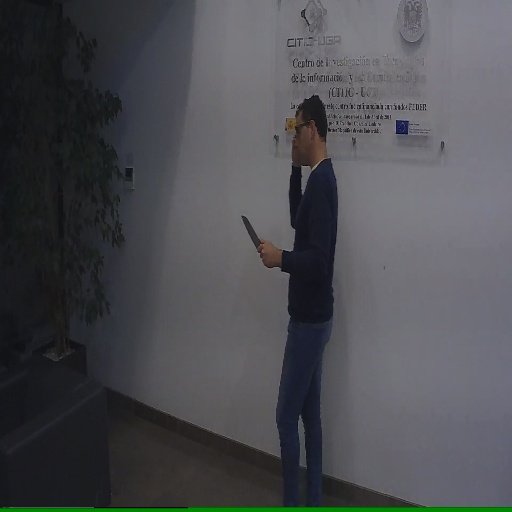

In [ ]:
# Check the paths for images and annotations
print("Image paths:", image_paths[:5])  # Print a few image paths to verify
print("Annotation paths:", annot_paths[:5])  # Print a few annotation paths to verify

# Display an example of an image and its associated annotation
example_idx = 0  # Change this index to check different examples
example_image = keras.utils.load_img(image_paths[example_idx])
example_annotation_path = annot_paths[example_idx]

print("Example image:")
display(example_image)

with open(example_annotation_path, 'r') as file:
    example_annotation = file.readline().split()
    print("Example annotation:", example_annotation)

In [ ]:
from posix import wait4

images, targets = [], []

# Load images and annotations, preprocess and store in lists
for i in range(len(image_paths)):
    # Access corresponding annotation path
    annot_path = os.path.join(path_annot, os.path.splitext(os.path.basename(image_paths[i]))[0] + '.txt')

    # Ensure annotation file exists for the current image
    if not os.path.exists(annot_path):
        continue

    with open(annot_path, 'r') as file:
        # Assuming annotations are stored in a specific format (e.g., x_min, y_min, x_max, y_max)
        # Modify this part based on your annotation file format
        annot = file.readline().split()
        class_label = int(annot[0])
        x_normalized = float(annot[1])
        y_normalized = float(annot[2])
        width_normalized = float(annot[3])
        height_normalized = float(annot[4])

    image = keras.utils.load_img(image_paths[i])
    (w, h) = image.size[:2]

    # Resize images
    image = image.resize((image_size, image_size))

    # Convert image to array and append to list
    images.append(keras.utils.img_to_array(image))

    # Apply relative scaling to bounding boxes as per given image and append to list
    targets.append([
        class_label,  # Add the class label
        x_normalized * w, # Denormalize
        y_normalized * h,
        width_normalized * w,
        height_normalized * h,
    ])

images_np, targets_np = np.asarray(images), np.asarray(targets)

# Convert the list to numpy array, split to train and test dataset
# Splitting images and targets into train and test subsets
train_images = images[: int(len(images) * 0.8)]
train_targets = targets[: int(len(targets) * 0.8)]
test_images = images[int(len(images) * 0.8) :]
test_targets = targets[int(len(targets) * 0.8) :]

# Convert the list to numpy array for both train and test
x_train, y_train = np.asarray(train_images), np.asarray(train_targets)
x_test, y_test = np.asarray(test_images), np.asarray(test_targets)


# Print shapes to check
print("Train shapes:", images_np.shape, targets_np.shape)


Train shapes: (4829, 224, 224, 3) (4829, 5)


In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    #     Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        # return patches
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])

Image size: 224 X 224
Patch size: 32 X 32
49 patches per image 
3072 elements per patch


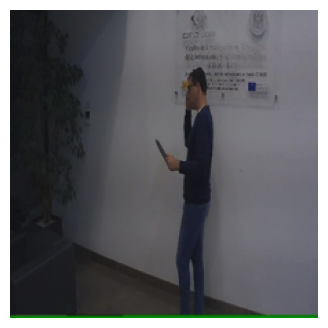

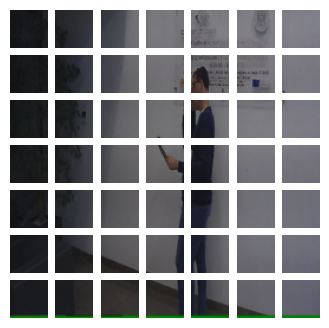

In [ ]:
patch_size = 32  # Size of the patches to be extracted from the input images

plt.figure(figsize=(4, 4))
plt.imshow(x_train[0].astype("uint8"))
plt.axis("off")

patches = Patches(patch_size)(tf.convert_to_tensor([x_train[0]]))
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")


n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    # Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
):
    inputs = layers.Input(shape=input_shape)
    # Create patches
    patches = Patches(patch_size)(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)

    bounding_box = layers.Dense(5)(
        features
    )  # Final four neurons that output bounding box

    # return Keras model.
    return keras.Model(inputs=inputs, outputs=bounding_box)

In [ ]:
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):

    optimizer = tf.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )


    # Compile model.
    model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=['accuracy'])
    # model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=['accuracy'])


    checkpoint_filepath = "logs/"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.3,
        callbacks=[
            checkpoint_callback,
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
        ],
    )

    return history


input_shape = (image_size, image_size, 3)  # input image shape
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 50
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [2048, 1024, 512, 64, 32]  # Size of the dense layers


history = []
num_patches = (image_size // patch_size) ** 2

vit_object_detector = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)

# Train model
history = run_experiment(
    vit_object_detector, learning_rate, weight_decay, batch_size, num_epochs
)

Epoch 1/50
85/85 [==============================] - 34s 260ms/step - loss: 18466.6094 - accuracy: 0.3225 - val_loss: 28514.3340 - val_accuracy: 0.1087
Epoch 2/50
85/85 [==============================] - 21s 242ms/step - loss: 13655.8877 - accuracy: 0.3602 - val_loss: 26203.6445 - val_accuracy: 0.1087
Epoch 3/50
85/85 [==============================] - 21s 247ms/step - loss: 12998.6895 - accuracy: 0.3828 - val_loss: 25246.0078 - val_accuracy: 0.1087
Epoch 4/50
85/85 [==============================] - 21s 244ms/step - loss: 12245.5596 - accuracy: 0.3728 - val_loss: 22220.5410 - val_accuracy: 0.1087
Epoch 5/50
85/85 [==============================] - 21s 246ms/step - loss: 12031.5840 - accuracy: 0.3750 - val_loss: 21047.0449 - val_accuracy: 0.1087
Epoch 6/50
85/85 [==============================] - 20s 240ms/step - loss: 11503.4502 - accuracy: 0.3813 - val_loss: 20549.7500 - val_accuracy: 0.1087
Epoch 7/50
85/85 [==============================] - 20s 237ms/step - loss: 11250.4922 - accura

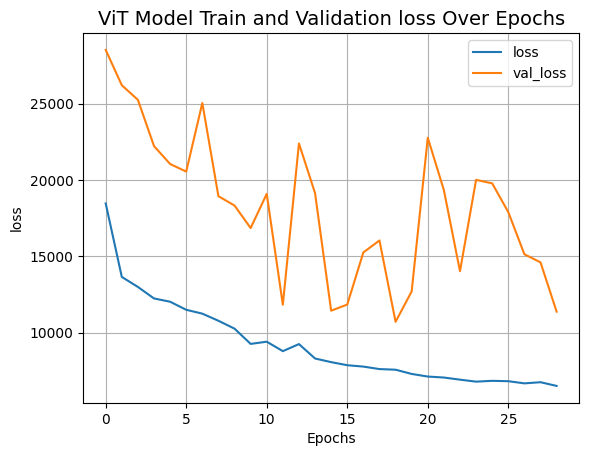

In [ ]:
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("ViT Model Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")


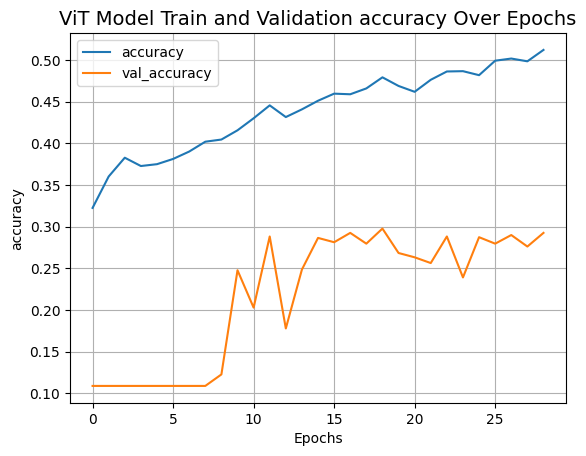

In [ ]:
plot_history("accuracy")

1/1 [==============================] - 0s 40ms/step
mean_iou: 0.40001989436623575


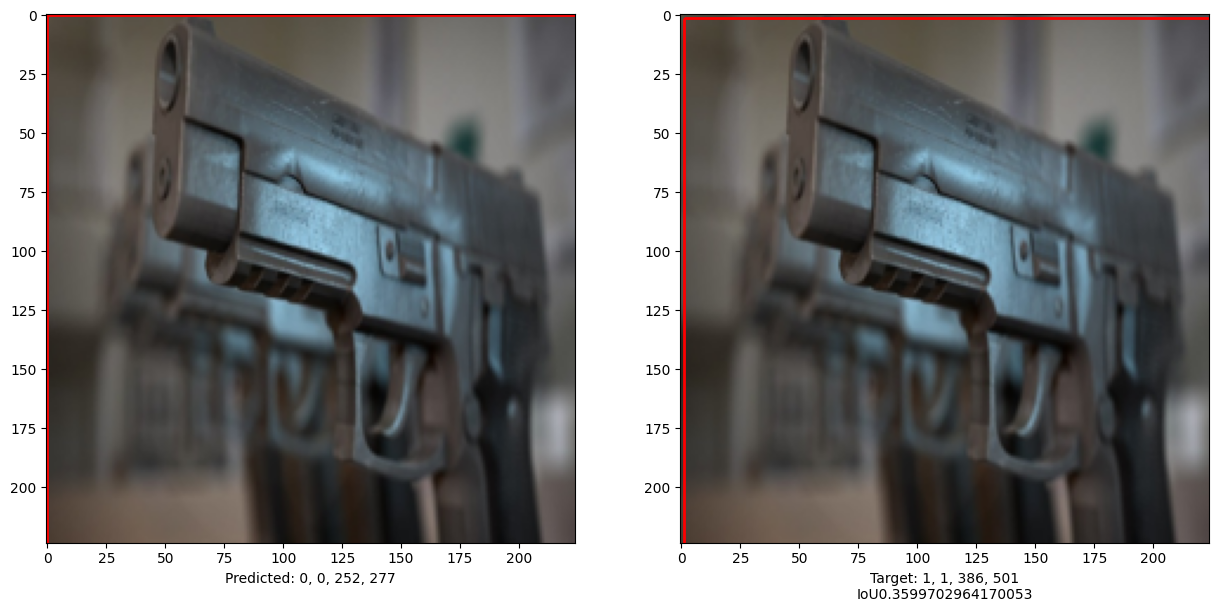

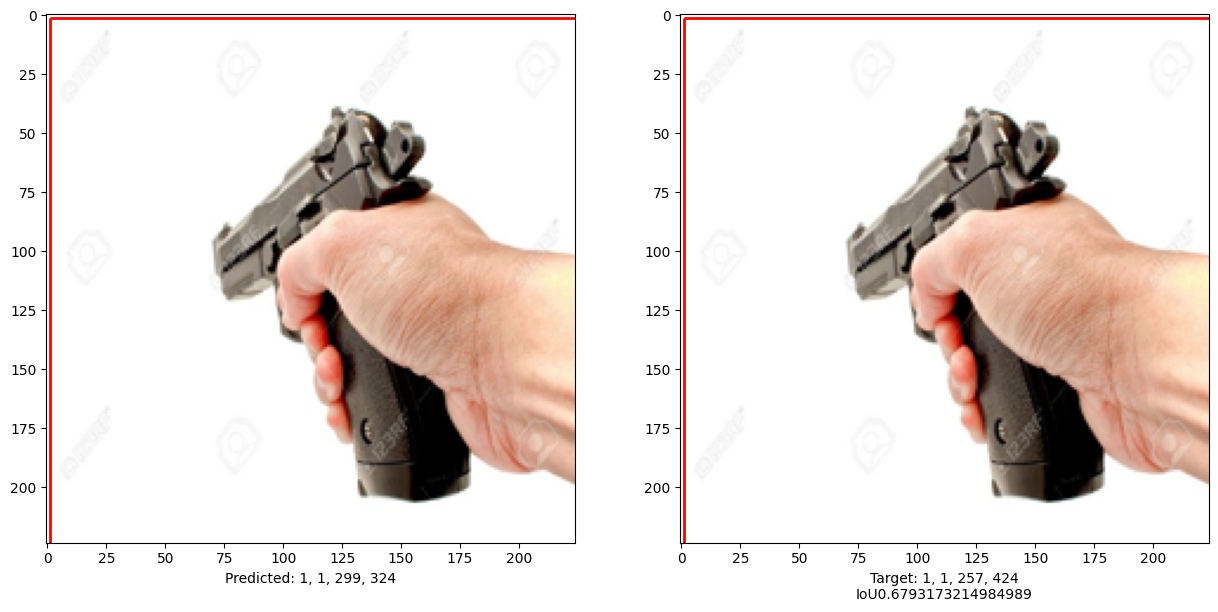

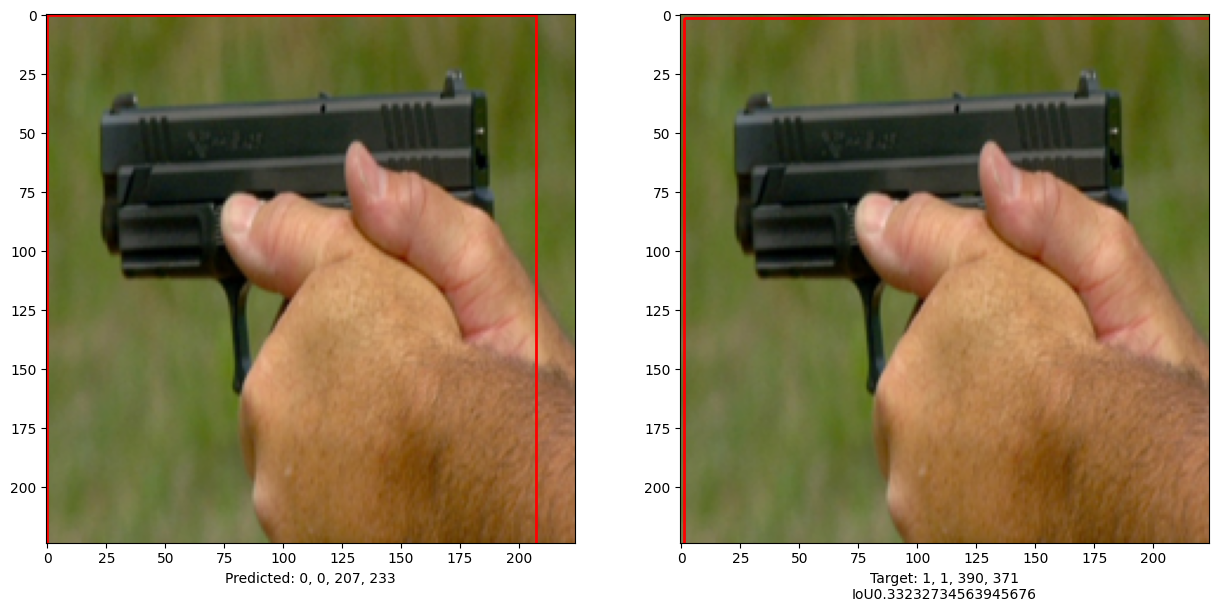

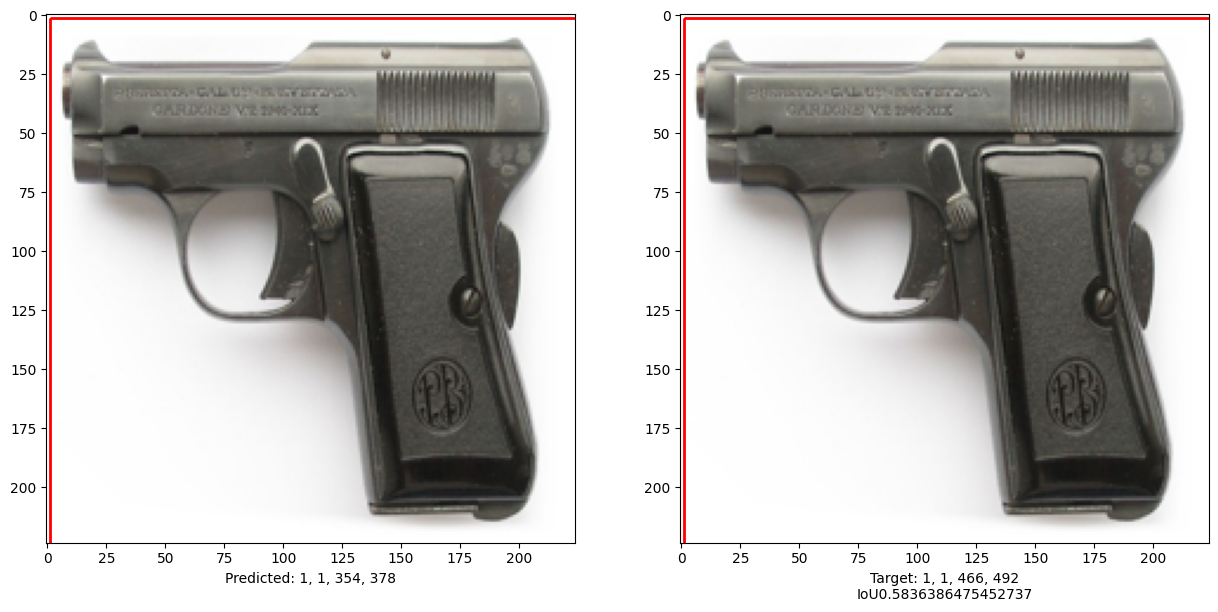

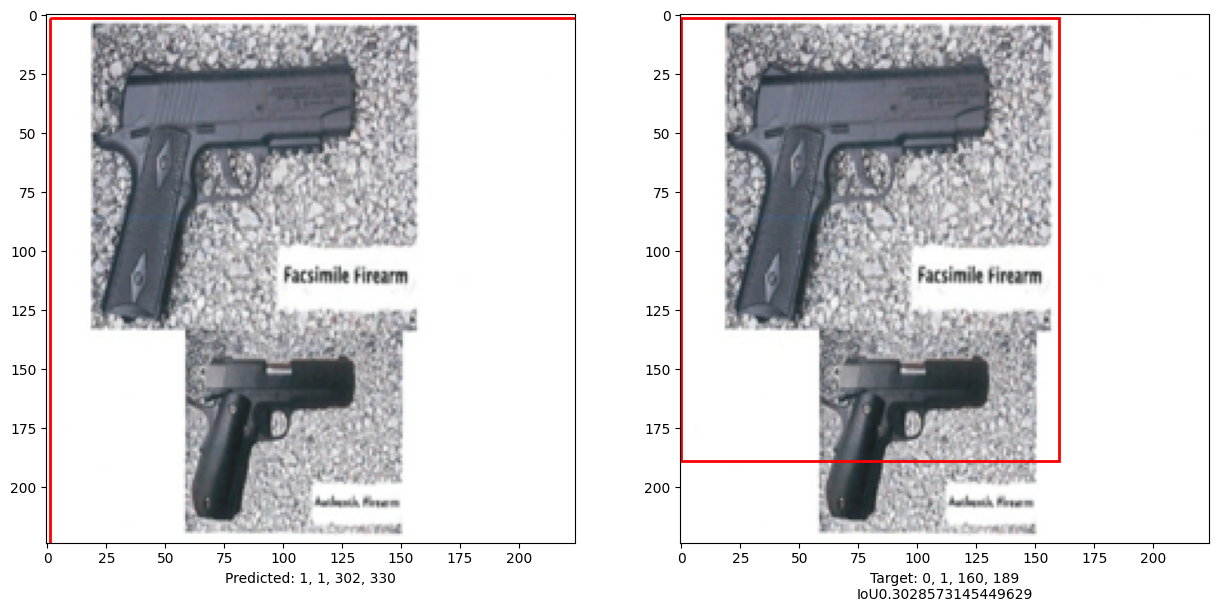

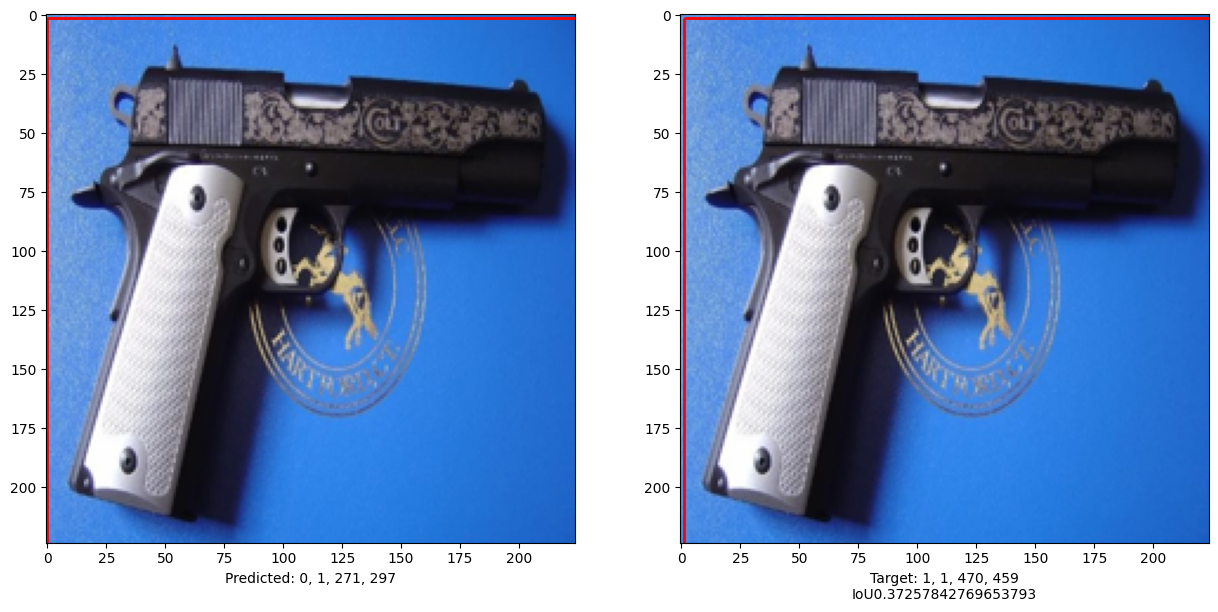

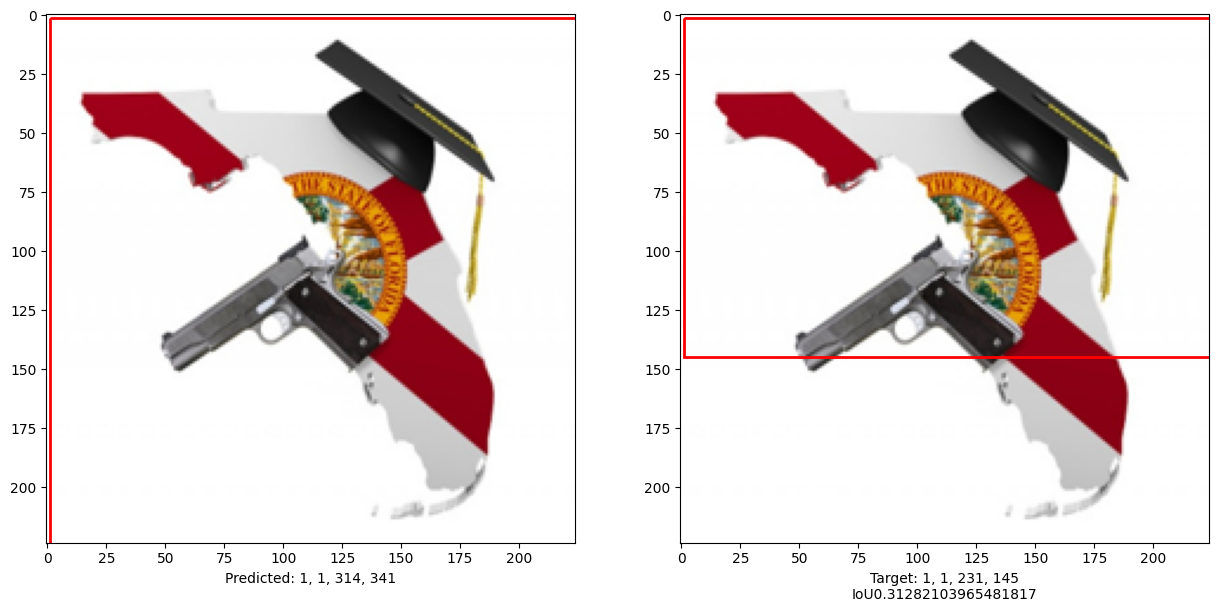

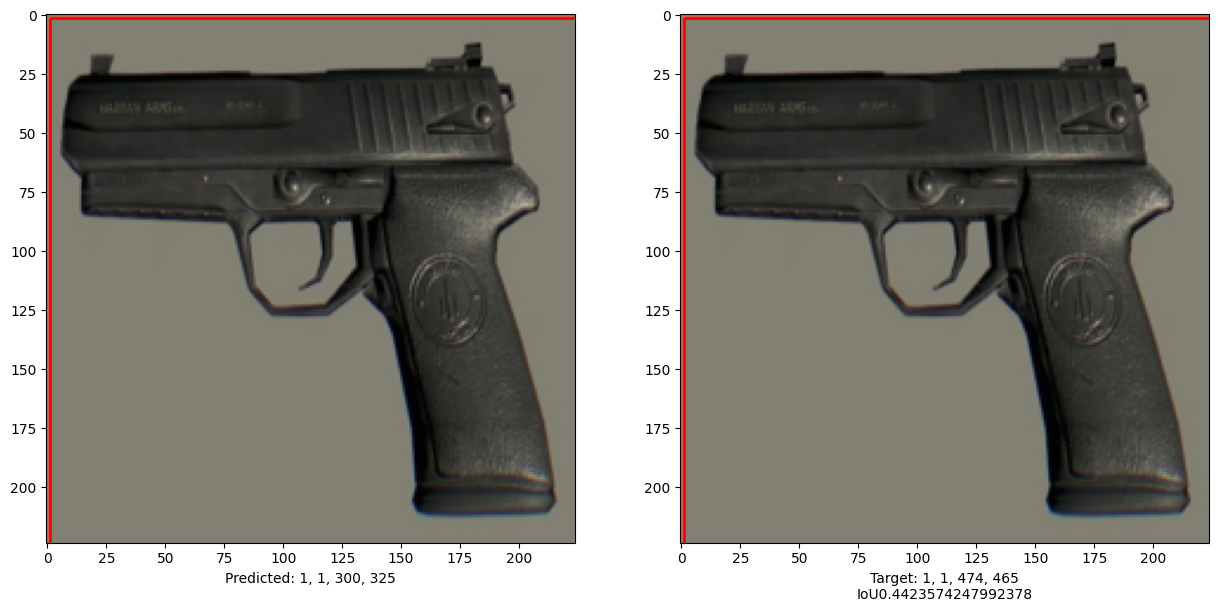

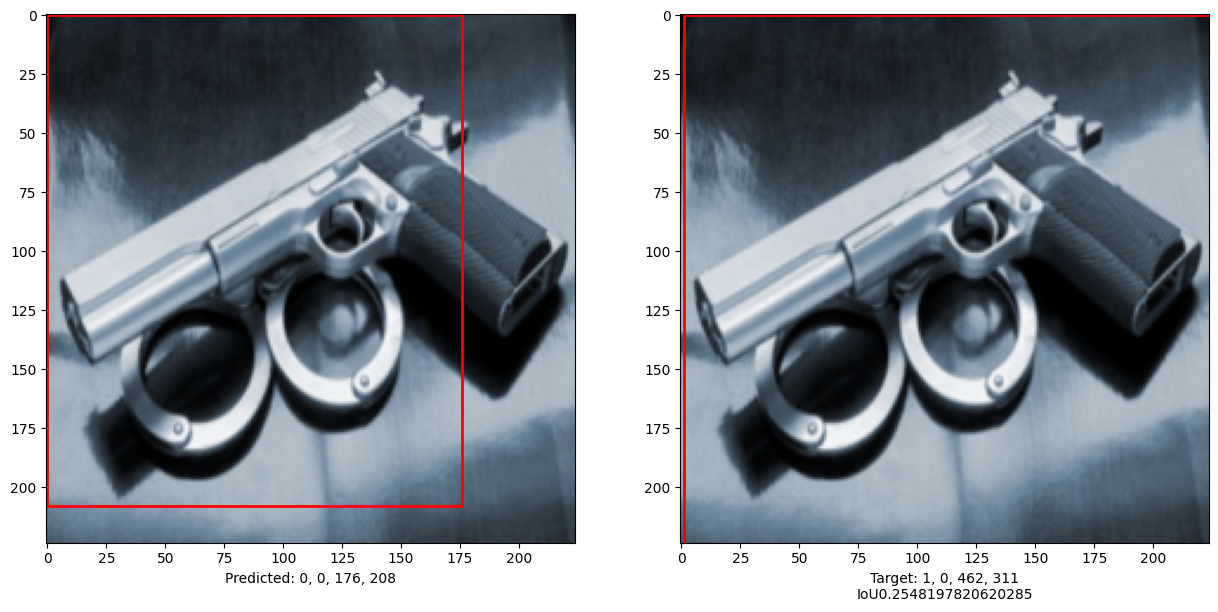

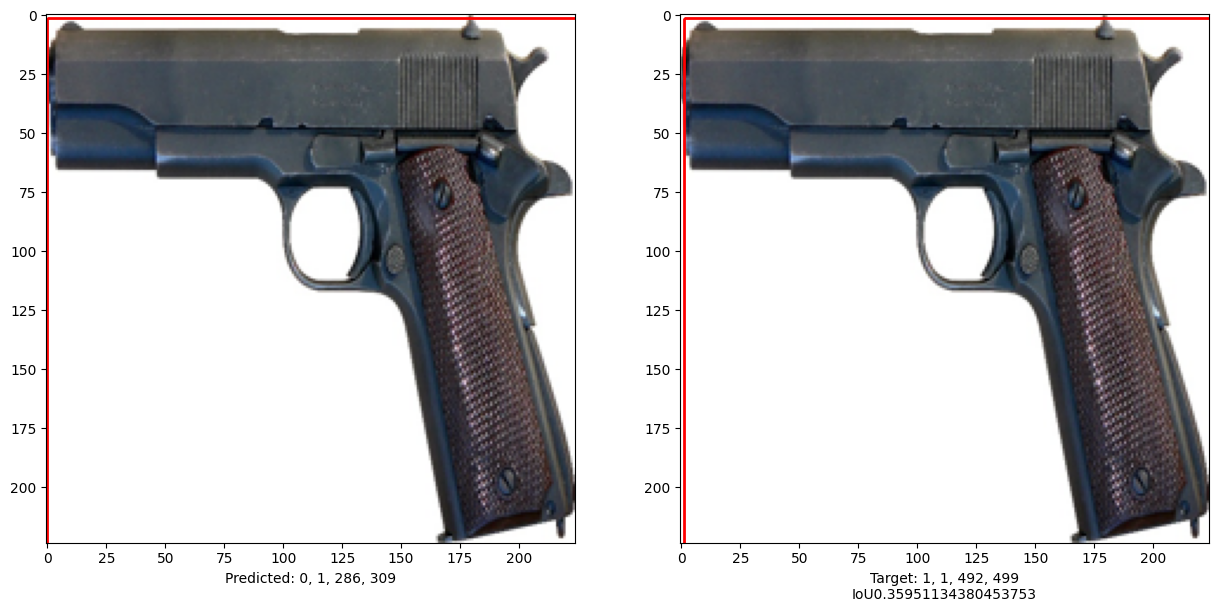

In [ ]:
import matplotlib.patches as patches

# Saves the model in current path
vit_object_detector.save("vit_object_detector.h5", save_format="h5")

# To calculate IoU (intersection over union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1)

    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1 )

    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1)

    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by  the interesection area

    # return ioU
    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area
    )


i, mean_iou = 0, 0

# Compare results for 10 images in the test set
for input_image in x_test[:10]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    im = input_image

    # Display the image
    ax1.imshow(im.astype("uint8"))
    ax2.imshow(im.astype("uint8"))

    input_image = cv2.resize(input_image, (image_size, image_size), interpolation=cv2.INTER_AREA)
    input_image = np.expand_dims(input_image, axis=0)
    preds = vit_object_detector.predict(input_image)[0]

    (h, w) = (im).shape[0:2]



    top_left_x, top_left_y = int(preds[1]/w), int(preds[2]/h)

    bottom_right_x, bottom_right_y = int(preds[3]), int(preds[4])

    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x,
        bottom_right_y,
        facecolor="none",
        edgecolor="red",
        linewidth=2,
    )
    # Add the bounding box to the image
    ax1.add_patch(rect)
    ax1.set_xlabel(
        "Predicted: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
    )


    top_left_x, top_left_y = int(y_test[i][1]/w), int(y_test[i][2]/h)

    bottom_right_x, bottom_right_y = int(y_test[i][3]), int(y_test[i][4])

    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

    #Test

    ttop_left_x, ttop_left_y = (((y_test[i][1]/w) - (y_test[i][3]/w)/2))*w, (((y_test[i][2]/h) - ((y_test[i][4]/h)/2)))*h

    tbottom_right_x, tbottom_right_y = ((y_test[i][3])), ((y_test[i][4]))

    tbox_truth = ttop_left_x, ttop_left_y, tbottom_right_x, tbottom_right_y

    ##

    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=2,
    )
    # Add the bounding box to the image
    ax2.add_patch(rect)
    ax2.set_xlabel(
        "Target: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
        + "\n"
        + "IoU"
        + str(bounding_box_intersection_over_union(box_predicted, box_truth))
    )
    i = i + 1

print("mean_iou: " + str(mean_iou / len(x_test[:10])))
plt.show()